# Comparing the Performance of Machine Learning Methods for Predicting Material Properties
This notebook makes some tests to assess the performance of different strategies in [Ward (2016)](https://www.nature.com/articles/npjcompumats201628) for predicting the properties of materials with machine learning. 
For the regression strategies, we use linear regression, Decision Tree, Rotation ForestRegressor and Random Subspace. For the classification strategies, we use Decision Tree, Rotation ForestRegressor and Random Subspace.
The data sets used in this notebook is boltztrap_mp, citrine_thermal_conductivity and glass_ternary_landolt.

In [1]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, BaggingClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, cross_val_predict, ShuffleSplit
from sklearn.base import BaseEstimator, clone
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from matminer.data_retrieval import retrieve_MDF
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from matminer.datasets import load_dataset
from RotationTree import RotationForestRegressor, RotationForestClassifier
import numpy as np
import pandas as pd
import math
import warnings
warnings.filterwarnings("ignore")

build the class for tunning model

In [2]:
class ModelTuner:
    '''Determines the best model parameters given a certain dataset'''

    def __init__(self, model, param_list):
        ''' Args:
            model (BaseEstimator): Model to be trained
            param_list ([(str, list)]): List of parameters to be tuned and the ranges of acceptable values
        '''
        self.model = model
        self.param_list = param_list
        self.model.get_params()

    def tune(self, X, y):
        '''Given a dataset, return a tuned model
        Args:
        X (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        Returns:
        - (BaseEstimator): Model with the tuned hyperparameters
        - (dict): Value of the parameters that were tuned for the best estimator'''
        # Clone model template
        model = clone(self.model)
        # Loop over all parameters to tune
        best_params = {}
        for param_name, param_values in self.param_list:
            # Create the grid search for tuning that parameter
            gs = GridSearchCV(model, {param_name: param_values}, cv=ShuffleSplit(n_splits=1, test_size=0.1))
            # Run the tuning
            gs.fit(X, y)
            # Get the best estimator
            model = gs.best_estimator_
            # Store the tuned values
            best_params.update(gs.best_params_)

        return model, best_params

build the function for making plots for regression strategies

In [34]:
def rresult(name,x,y,model):
    '''calculate the MSE of a regression model and make a plot for the measured values and predicted values
    
        Args:
        name (str): Property to be predicted
        x (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        model (BaseEstimator): model has been tuned which has the best params
        
        Returns:
        - (float): value fo the MSE
    
    '''
    # calculate the MSE with 10-fold cross validation
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    cv_prediction = cross_val_predict(model, x, y, cv=crossvalidation)
    # get the MSE
    e = getattr(metrics,'mean_absolute_error')(y, cv_prediction)
    # make plots
    fig, ax = plt.subplots()
    ax.scatter(y, cv_prediction, edgecolors=(0, 0, 0))
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
    ax.set_xlabel(name + '_' + 'Measured')
    ax.set_ylabel(name + '-' + 'Predicted')
    plt.show()
    print(name,e)
    return e

build the function for displaying the accuracy of the classification strategies 

In [4]:
def cresult(name,x,y,model):
    
    '''calculate the accuracy of a classification model
    
        Args:
        name (str): Property to be predicted
        x (ndarray): List of features for each entry
        y (ndarray): List of labels for each entry
        model (BaseEstimator): model has been tuned which has the best params
        
        Returns:
        - (float): value of the accuracy
    
    '''
    # calculate the MSE with 10-fold cross validation
    crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(model, x, y, cv=crossvalidation)
    # get the MSE
    mse_scores = [abs(s) for s in scores]
    e =  np.mean(mse_scores)
    print(name,e)
    return e

build the function for transforming the raw data to composition based features (Ward et al 2016) and tuning the model

In [32]:
def test(df,prediction,attribute,regression,preprocess,model_tuner,recordfile,dataname):
    '''do some tests with different datasets and different machine learning methods
    
        Args:
        df (dataframe): Dataset to be trained
        prediction (str): Property to be predicted
        attribute (str): Features to be trained
        regression (bool): Whether or not to figure a regression problem
        preprocess (bool): Whether or not to do preprocess on the values of the predicted property
        model_tuner ([ModelTuner]): Model to be trained
        recordfile (list): List of str contains the name of record files
        dataname (str): The name of the dataset
    
    '''
    #get the data we need
    data = df[[prediction, attribute]]
    #rename the columns
    data = data.rename(columns={prediction:prediction,  attribute:'composition'})
    data = StrToComposition(target_col_id='composition_obj').featurize_dataframe(data, 'composition')
    #remove the entry of which the value of property is None
    data = data[data[prediction]!='None']
    for k in [prediction]:
        data[k] = pd.to_numeric(data[k])

    original_count = len(data)
    #Remove entries with NaN or infinite property
    data = data[~ data[prediction].isnull()]
    print('Removed %d/%d entries with NaN or infinite property'%(original_count - len(data), original_count))

    #Get only the groundstate and each composition
    original_count = len(data)
    data['composition'] = data['composition_obj'].apply(lambda x: x.reduced_formula)
    data.sort_values(prediction, ascending=True, inplace=True)
    data.drop_duplicates('composition', keep='first', inplace=True)
    print('Removed %d/%d duplicate entries '%(original_count - len(data), original_count))
    
    #convert the raw materials data into the required input for an ML model: a finite list of quantitative attributes. 
    feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                              cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
    feature_labels = feature_calculators.feature_labels()

    #Compute the features
    data = feature_calculators.featurize_dataframe(data, col_id='composition_obj')

    print('Generated %d features'%len(feature_labels))
    print('Training set size:', 'x'.join([str(x) for x in data[feature_labels].shape]))

    original_count = len(data)
    #Remove entries with NaN or infinite features
    data = data[~ data[feature_labels].isnull().any(axis=1)]
    print('Removed %d/%d entries with NaN or infinite features'%(original_count - len(data), original_count))
    #if the value of property need preprocessing use log() to transform the original values 
    if preprocess:
        data.loc[:,prediction] =  np.log(df.loc[:,prediction]-2*min(df.loc[:,prediction])) 
    #Remove entries with NaN or infinite property
    data = data[~ data[prediction].isnull()]
    print('Removed %d/%d entries with NaN or infinite property'%(original_count - len(data), original_count))
    #if a regression problem we need to do a linear regression
    if regression == True:
        rresult(prediction,data[feature_labels], data[prediction],LinearRegression())
    #train different models
    for i in range(len(model_tuner)): 
        model, best_params = model_tuner[i].tune(data[feature_labels],data[prediction])
        if regression == True:
            score = rresult(prediction,data[feature_labels], data[prediction],model)
            best_params['MSE'] = score
        else:
            score = cresult(prediction,data[feature_labels], data[prediction],model)
            best_params['Accuracy'] = score
        #save the best params for each model to the disk
        (pd.DataFrame(best_params,index = [dataname+'_'+prediction] )).to_csv(recordfile[i],mode='a')

# Initialize models and params to be tuned 
For decision tree, we try to tune the number of features to consider each time to make the split decision and max depth of the tree.
For rotation forest, we try to tune the number of features in each subset and number of features to consider each time to make the split decision. 
For random subspace, we try to tune the number of features to draw from data to train each decision tree and the number of decision tree in the model.

In [6]:
#calculate the number of features for each subset for the rotation forest
features = []
for i in range(14,145):
    features.append(int(145/i))
features = list(set(features))
#list contains the regression models to be trained
rmodel = [DecisionTreeRegressor(),RotationForestRegressor(),BaggingRegressor(DecisionTreeRegressor())]
#list contains the classification models to be trained
cmodel = [DecisionTreeClassifier(),RotationForestClassifier(),BaggingClassifier(DecisionTreeClassifier())]
#list contains the params to be tuned for each model
params = [[('max_features',range(5,15)),('max_depth',range(10,100,10))],[('n_features_per_subset',features),('max_features',range(10,15))],[('max_features',[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]),('n_estimators',range(1,10))]]
#list contains the file name for recording the best params for each models
recordfile = ['DecisionTreeRegressor.csv','RotationForestRegressor.csv','RandomSubspace.csv']
rmodeltuner = []
cmodeltuner = []
for i in range(len(params)):
    rmodeltuner.append(ModelTuner(rmodel[i],params[i]))
    cmodeltuner.append(ModelTuner(cmodel[i],params[i]))

Load the dataset bolztrap for regression problems 

In [7]:
%%time
df = load_dataset('boltztrap_mp')

CPU times: user 9.79 s, sys: 320 ms, total: 10.1 s
Wall time: 10.1 s


In [8]:
df.columns

Index(['mpid', 'pf_n', 'pf_p', 's_n', 's_p', 'formula', 'm_n', 'm_p',
       'structure'],
      dtype='object')

In [9]:
df.head(2)

,mpid,pf_n,pf_p,s_n,s_p,formula,m_n,m_p,structure
0,mp-10070,0.865,0.0125,-421.0,760.0,BaAg(PO3)3,0.578,72.80,"[[ 0.08245398 10.58009491 11.61923254] O, [3.1..."
1,mp-10086,1.050,0.6440,-393.0,567.0,YSF,0.541,4.02,"[[2.84699546 0.94899849 0. ] F, [0.9489..."



Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 1/7380 entries with NaN or infinite property


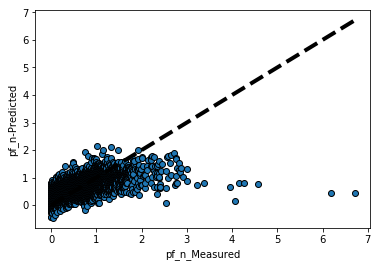

pf_n 0.24577598261879754


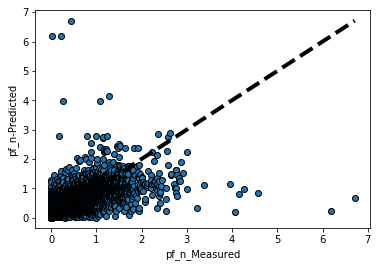

pf_n 0.25445311783524566


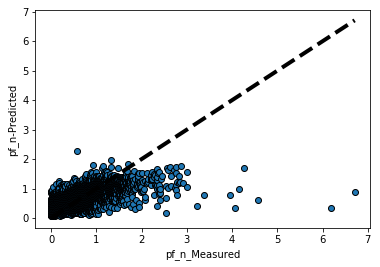

pf_n 0.22352464503752376


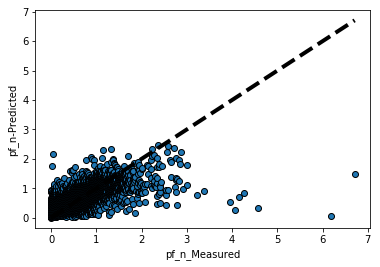

pf_n 0.21075653259743954
CPU times: user 7min 6s, sys: 16.8 s, total: 7min 23s
Wall time: 2min 39s


In [10]:
%%time
test(df,'pf_n','formula',True,False,rmodeltuner,recordfile,'boltztrap_mp')


Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 1/7380 entries with NaN or infinite property


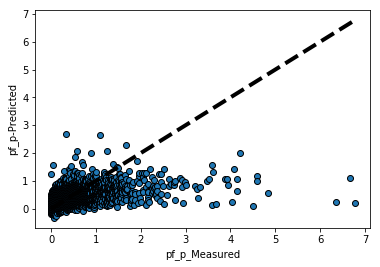

pf_p 0.20528405469514774


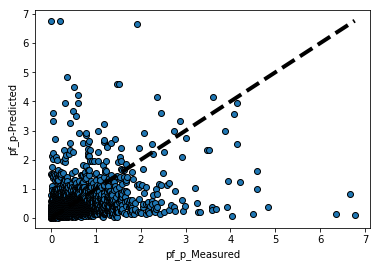

pf_p 0.2165498839757699


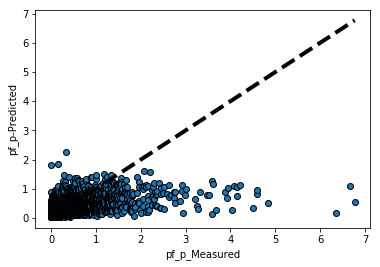

pf_p 0.19508436423359785


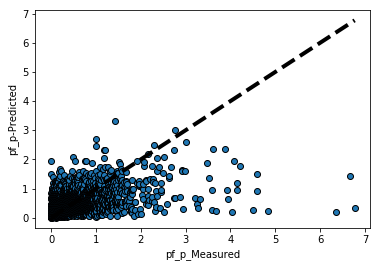

pf_p 0.1924036170644957
CPU times: user 7min 20s, sys: 17.2 s, total: 7min 37s
Wall time: 3min 1s


In [11]:
%%time
test(df,'pf_p','formula',True,False,rmodeltuner,recordfile,'boltztrap_mp')


Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 1/7380 entries with NaN or infinite property


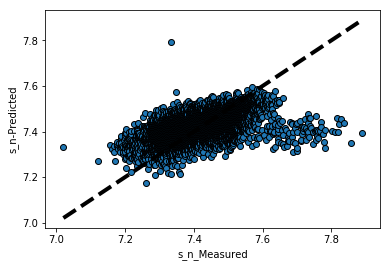

s_n 0.05776037923259284


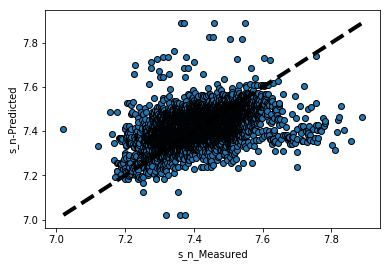

s_n 0.05974327727656115


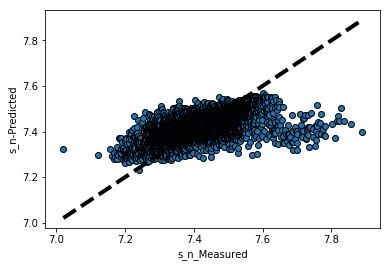

s_n 0.052914518743490936


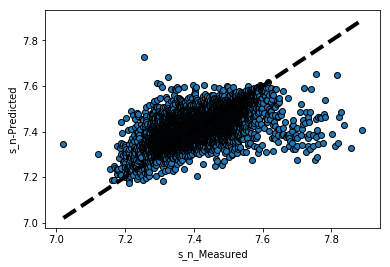

s_n 0.05084532045433204
CPU times: user 7min 48s, sys: 16.7 s, total: 8min 5s
Wall time: 2min 51s


In [12]:
%%time
test(df,'s_n','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')


Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 1/7380 entries with NaN or infinite property


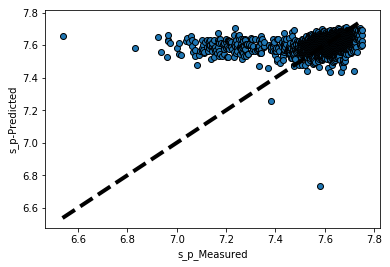

s_p 0.04154596896141468


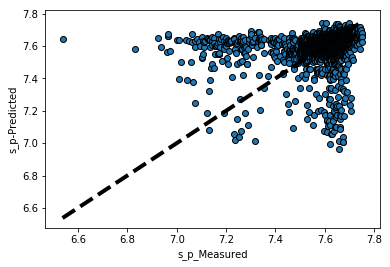

s_p 0.045410792106785364


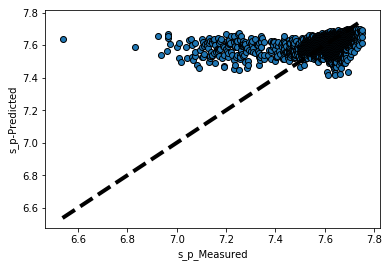

s_p 0.03969968633987944


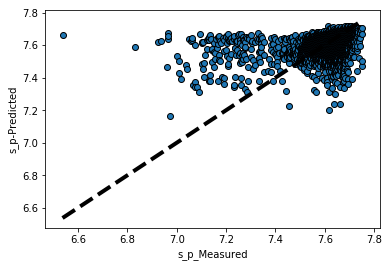

s_p 0.04341856200709173
CPU times: user 7min 56s, sys: 21.3 s, total: 8min 18s
Wall time: 3min 4s


In [13]:
%%time
test(df,'s_p','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')


Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 4/7380 entries with NaN or infinite property


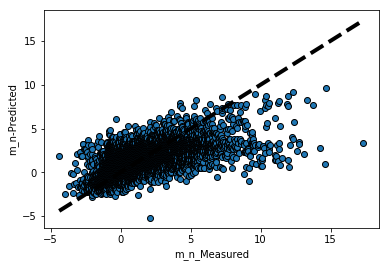

m_n 1.31746262838199


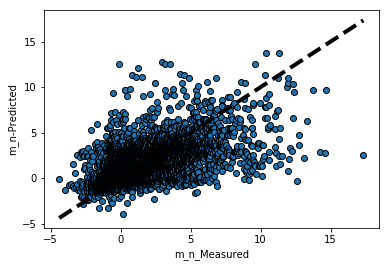

m_n 1.3286157308547584


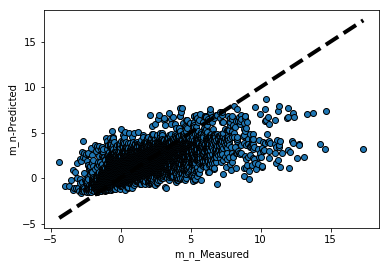

m_n 1.1898526419607482


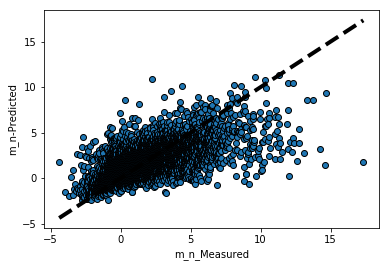

m_n 1.1488454950779876
CPU times: user 8min 16s, sys: 19.6 s, total: 8min 36s
Wall time: 2min 50s


In [14]:
%%time
test(df,'m_n','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')


Removed 0/8924 entries with NaN or infinite property
Removed 1544/8924 duplicate entries 



Generated 145 features
Training set size: 7380x145
Removed 1/7380 entries with NaN or infinite features
Removed 4/7380 entries with NaN or infinite property


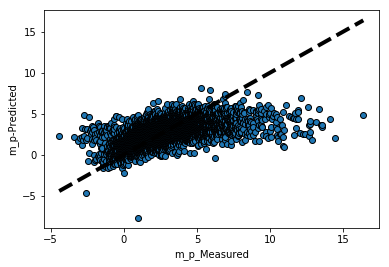

m_p 1.157813131164058


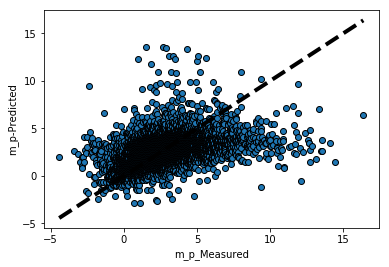

m_p 1.3062556334241582


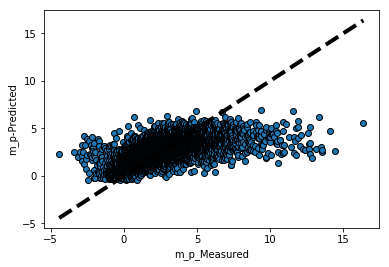

m_p 1.1606745988364604


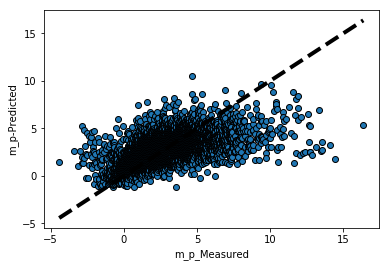

m_p 1.1590113856944175
CPU times: user 7min 2s, sys: 18 s, total: 7min 20s
Wall time: 2min 51s


In [15]:
%%time
test(df,'m_p','formula',True,True,rmodeltuner,recordfile,'boltztrap_mp')

Load the dataset citrine_thermal_conductivity for regression problems 

In [24]:
%%time
df = load_dataset('citrine_thermal_conductivity')
df = df[(df['k_condition'].isin([300, 'room temperature', 'Room temperature', '298']))]

CPU times: user 23.2 ms, sys: 18.1 ms, total: 41.3 ms
Wall time: 37.8 ms


In [17]:
df.columns

Index(['formula', 'k_expt', 'k-units', 'k_condition', 'k_condition_units'], dtype='object')

In [18]:
df.head(2)

,formula,k_expt,k-units,k_condition,k_condition_units
0,BeS,157.0,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."
1,CdS,19.9,W/m.K,room temperature,"[{'name': 'Temperature', 'scalars': [{'value':..."



Removed 0/83 entries with NaN or infinite property
Removed 36/83 duplicate entries 



Generated 145 features
Training set size: 47x145
Removed 0/47 entries with NaN or infinite features
Removed 1/47 entries with NaN or infinite property
-0.3856624808119846 7.985967561959119


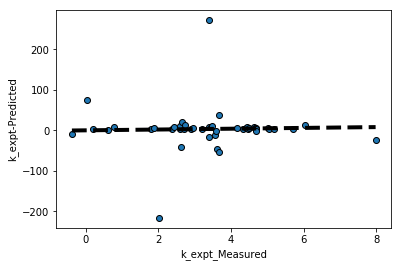

k_expt 20.512034473837513
-0.3856624808119846 7.985967561959119


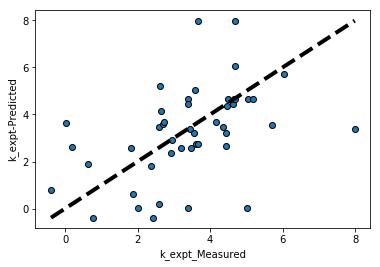

k_expt 1.4035683546427506
-0.3856624808119846 7.985967561959119


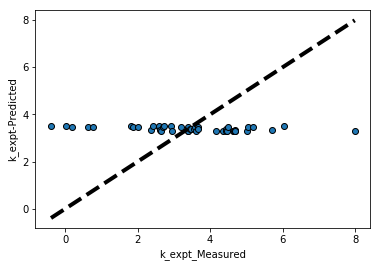

k_expt 1.2663538341254992
-0.3856624808119846 7.985967561959119


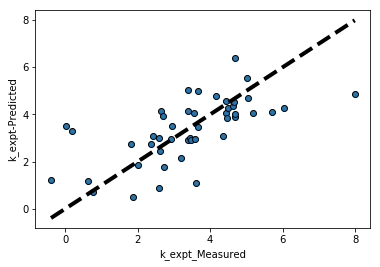

k_expt 0.9665151369395827
CPU times: user 29.1 s, sys: 3.24 s, total: 32.3 s
Wall time: 8.84 s


In [33]:
%%time
test(df,'k_expt','formula',True,True,rmodeltuner,recordfile,'citrine_thermal_conductivity')

Load the dataset glass_ternary_landolt for classification problems 

In [20]:
%%time
df = load_dataset('glass_ternary_landolt')
df=df[(df['processing'].isin(['meltspin']))]

CPU times: user 93.4 ms, sys: 13.8 ms, total: 107 ms
Wall time: 36.9 ms


In [21]:
df.columns

Index(['formula', 'phase', 'processing', 'gfa'], dtype='object')

In [22]:
df.head(2)

,formula,phase,processing,gfa
0,Ag20Al25La55,AM,meltspin,1
1,Ag15Al10Mg75,AM,meltspin,1


In [23]:
%%time
test(df,'gfa','formula',False,False,cmodeltuner,recordfile,'glass_ternary_landolt')


Removed 0/6780 entries with NaN or infinite property
Removed 1467/6780 duplicate entries 



Generated 145 features
Training set size: 5313x145
Removed 0/5313 entries with NaN or infinite features
Removed 0/5313 entries with NaN or infinite property
gfa 0.858845206235929
gfa 0.8831216459227162
gfa 0.8752177052801494
CPU times: user 6min 17s, sys: 19.1 s, total: 6min 37s
Wall time: 2min 32s
